In [ ]:
#@title Computer ko aang lagani ho to hi ched chad karna

!pip install git+https://github.com/openai/glide-text2im

from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-0wjo_zcd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/glide-text2im /tmp/pip-req-build-0wjo_zcd
  Resolved https://github.com/openai/glide-text2im to commit 69b530740eb6cef69442d6180579ef5ba9ef063e
  Preparing metadata (setup.py) ... done
total base parameters 385030726
total upsampler parameters 398361286


In [ ]:
#@title Image Processing function

def text2image(image_description,batch_size,guidance_scale):
  # Sampling parameters
  # image_description = "dog in the field" #@param {type:"string"}
  # image_description = ""
  #batch_size = 1 #@param {type:"integer"}
  #guidance_scale = 8.0

  # Tune this parameter to control the sharpness of 256x256 images.
  # A value of 1.0 is sharper, but sometimes results in grainy artifacts.
  upsample_temp = 0.997

  ##############################
  # Sample from the base model #
  ##############################

  # Create the text tokens to feed to the model.
  tokens = model.tokenizer.encode(image_description)
  tokens, mask = model.tokenizer.padded_tokens_and_mask(
      tokens, options['text_ctx']
  )

  # Create the classifier-free guidance tokens (empty)
  full_batch_size = batch_size * 2
  uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
      [], options['text_ctx']
  )

  # Pack the tokens together into model kwargs.
  model_kwargs = dict(
      tokens=th.tensor(
          [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
      ),
      mask=th.tensor(
          [mask] * batch_size + [uncond_mask] * batch_size,
          dtype=th.bool,
          device=device,
      ),
  )

  # Create a classifier-free guidance sampling function
  def model_fn(x_t, ts, **kwargs):
      half = x_t[: len(x_t) // 2]
      combined = th.cat([half, half], dim=0)
      model_out = model(combined, ts, **kwargs)
      eps, rest = model_out[:, :3], model_out[:, 3:]
      cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
      half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
      eps = th.cat([half_eps, half_eps], dim=0)
      return th.cat([eps, rest], dim=1)

  # Sample from the base model.
  model.del_cache()
  samples = diffusion.p_sample_loop(
      model_fn,
      (full_batch_size, 3, options["image_size"], options["image_size"]),
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
  )[:batch_size]
  model.del_cache()

  # Show the output
  show_images(samples)


  ##############################
  # Upsample the 64x64 samples #
  ##############################

  tokens = model_up.tokenizer.encode(image_description)
  tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
      tokens, options_up['text_ctx']
  )

  # Create the model conditioning dict.
  model_kwargs = dict(
      # Low-res image to upsample.
      low_res=((samples+1)*127.5).round()/127.5 - 1,

      # Text tokens
      tokens=th.tensor(
          [tokens] * batch_size, device=device
      ),
      mask=th.tensor(
          [mask] * batch_size,
          dtype=th.bool,
          device=device,
      ),
  )

  # Sample from the base model.
  model_up.del_cache()
  up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
  image = diffusion_up.ddim_sample_loop(
      model_up,
      up_shape,
      noise=th.randn(up_shape, device=device) * upsample_temp,
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
  )[:batch_size]
  model_up.del_cache()

  # Show the output
  show_images(image)
  return image



  0%|          | 0/100 [00:00<?, ?it/s]

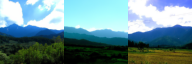

  0%|          | 0/27 [00:00<?, ?it/s]

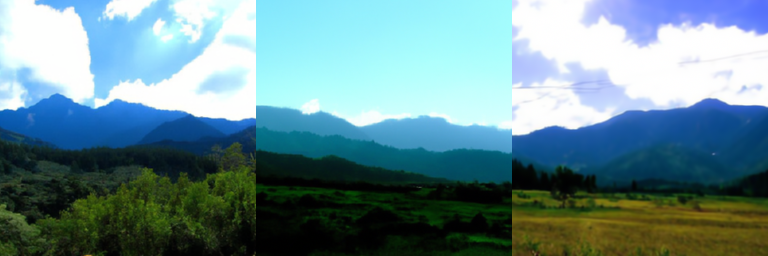

tensor([[[[ 0.6063,  0.6501,  0.6802,  ...,  0.9911,  0.9956,  1.0000],
          [ 0.6170,  0.6566,  0.6894,  ...,  0.9919,  0.9956,  0.9995],
          [ 0.6112,  0.6505,  0.6800,  ...,  0.9929,  0.9964,  0.9992],
          ...,
          [-0.7414, -0.6698, -0.6879,  ..., -0.9332, -0.7570, -0.6743],
          [-0.7740, -0.7380, -0.7203,  ..., -0.7928, -0.7047, -0.8421],
          [-0.7804, -0.6801, -0.6272,  ..., -0.4227, -0.3367, -0.8099]],

         [[ 0.8664,  0.9122,  0.9388,  ...,  0.9938,  0.9952,  0.9999],
          [ 0.8742,  0.9213,  0.9475,  ...,  0.9932,  0.9965,  0.9961],
          [ 0.8757,  0.9151,  0.9394,  ...,  0.9943,  0.9986,  0.9977],
          ...,
          [-0.5621, -0.4886, -0.5021,  ..., -0.9461, -0.7559, -0.6579],
          [-0.5998, -0.5518, -0.5386,  ..., -0.7900, -0.6947, -0.8386],
          [-0.5998, -0.4812, -0.4317,  ..., -0.4007, -0.3218, -0.8276]],

         [[ 0.9669,  0.9800,  0.9880,  ...,  0.9902,  0.9910,  0.9962],
          [ 0.9640,  0.9756,  

In [ ]:
#@title Generate the images

input_prompt = "Scenery of Mountains" #@param
batch_size = 3 #@param
guidance_scale = 10.0 #@param
text2image(input_prompt,batch_size,guidance_scale)